### CNN for density estimation and counting

Density maps are an interesting target for CNNs.  Density maps allow you estimate dense populations without having to necessarily identify each individual in the population. My goal is to create a fully convolutional model capable of producing density maps.

A key insight that makes this approach easier than others is the way we can generate density maps from unlabeled data. While this may still be a time consuming process for extremely dense images, the labeling process only requires you to place single points on each instance of the object as opposed to bounding boxes or detailed segmentation.  

With a point map in place for a source image we can convolve a gaussian kernel with a mean of one to generate the density map. A sum over the image array will yield a count of points that is the same before and after the points map has been turned into a density map.

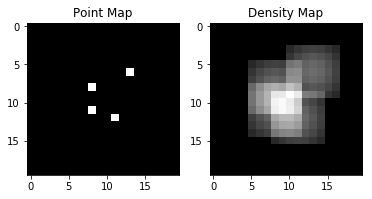

Sum of points on point map 4.0
Sum of points on density map 4.0


In [1]:
# here we will create a simple density map to illustrate the concept of turning a point map into a density map

import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# load the point map and ensure it's grayscale. at this step it's important to reduce the image to 1 channel
# so our future sum operation counts the point only once. the background is black and points are white
point_map_file = './points.png'
point_map = cv2.cvtColor(cv2.imread(point_map_file), cv2.COLOR_BGR2GRAY)

# black background doesn't change (0/255 = 0) however the white points are now 1 (255/255 = 1)
# again, important for the future sum operation
point_map = point_map / 255

# now we can convolve a gaussian kernel over the point map
density_map = cv2.GaussianBlur(point_map, (7,7), 3)

plt.subplot(121)
plt.title('Point Map')
plt.imshow(point_map, interpolation='none', cmap='gray')
plt.subplot(122)
plt.title('Density Map')
plt.imshow(density_map, interpolation='none', cmap='gray')
plt.show()

print('Sum of points on point map', point_map.sum())
print('Sum of points on density map', density_map.sum())


Great, we can demonstrate that density maps are working as expected. We can count the original sum of points even though the image has been blurred. We will create a CNN to output the same type of density map, to count crowds, or anything that has a point map!

### Augmentation for training

I'll use Keras to build the CNN and perform some of the training augmentation, but we need to do some more advanced augmentation as well!

To generate the training data we'll use an image pyramid and a sliding window, passing a window of a static size over every pyramid level, with a bit of overlap at every step. The idea here is to make the network aware of multiple zoom levels, and to generate many training examples from just one image.

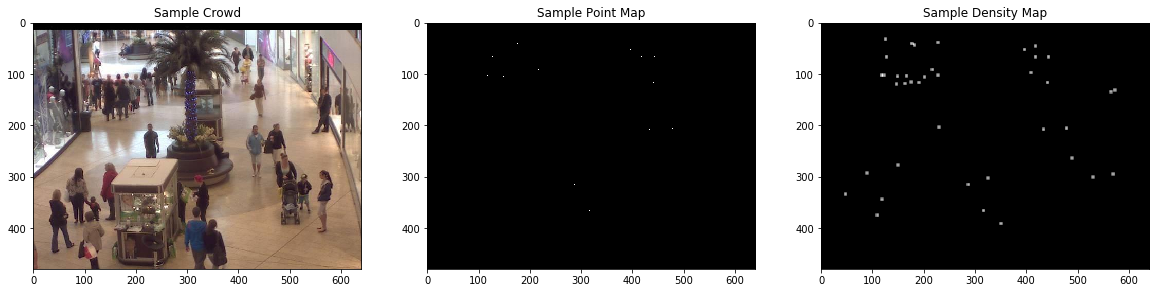

Image size (480, 640, 3)
Sum of points on point map 39.0
Sum of points on density map 39.0


In [2]:
# here's what the training images look like. in this dataset all images are from 
# this one camera and contain varying numbers of people 

# load the sample files
sample_crowd_file = './sample_crowd.jpg'
sample_crowd_point_map_file = './sample_crowd_point_map.png'
sample_crowd_img = cv2.cvtColor(cv2.imread(sample_crowd_file), cv2.COLOR_BGR2RGB)
sample_crowd_point_map_img = cv2.cvtColor(cv2.imread(sample_crowd_point_map_file), cv2.COLOR_BGR2GRAY)

# scale the point maps to zeros and ones
sample_crowd_point_map_img = sample_crowd_point_map_img / 255

# create the density map from the point map
sample_crowd_density_map_img = cv2.GaussianBlur(sample_crowd_point_map_img, (7,7), 3)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Sample Crowd')
plt.imshow(sample_crowd_img)
plt.subplot(132)
plt.title('Sample Point Map')
plt.imshow(sample_crowd_point_map_img, interpolation='none', cmap='gray')
plt.subplot(133)
plt.title('Sample Density Map')
plt.imshow(sample_crowd_density_map_img, interpolation='none', cmap='gray')

plt.show()

print('Image size', sample_crowd_img.shape)
print('Sum of points on point map', sample_crowd_point_map_img.sum())
print('Sum of points on density map', sample_crowd_density_map_img.sum())

### Image pyramid based augmentation

With an image pyramid we can teach the network to learn varying scales of representation. An image pyramid is a simple idea, you take the original image at 100% and scale it up and down to create a 'pyramid', and here I'll make the pyramid from images thate are 60%-120% scale at intervals of 10%. With the scaled images now created in the pyramid we'll slide a window of a static size over every scale. With the window at position 1, take the sample from the window, then move the window and take another and repeat over all images.

We will also need to create scaled point maps, and even though we can think of point maps as images, standard image scaling will not maintain the point counting ability that is critical to the overall approach. To address this we will scale each point individually, discover its new translated coordinate, and re-create the point maps with these new locations.

First we'll create the image pyramid, and then work on the sliding window.

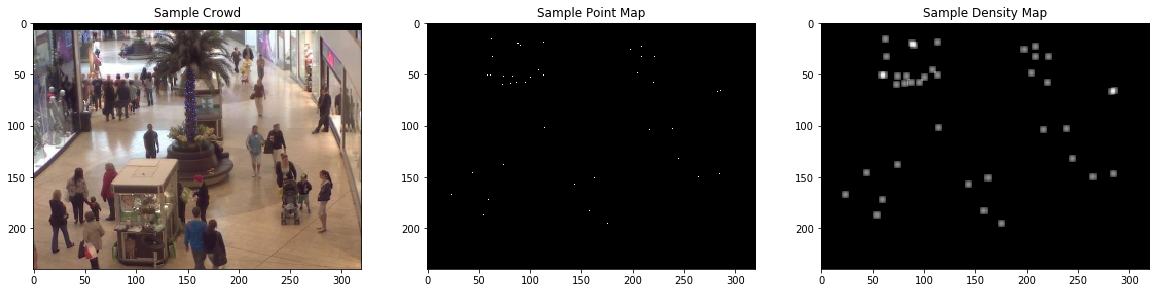

Using scale factor: 0.5
Original image has size (480, 640, 3) Scaled image has size (240, 320, 3) With point count 39.0

Zoom level: 0.5 Scaled size: (240, 320, 3)
Zoom level: 0.6 Scaled size: (288, 384, 3)
Zoom level: 0.7 Scaled size: (336, 448, 3)
Zoom level: 0.8 Scaled size: (384, 512, 3)
Zoom level: 1.0 Scaled size: (480, 640, 3)
Zoom level: 1.1 Scaled size: (528, 704, 3)
Zoom level: 1.2 Scaled size: (576, 768, 3)


In [3]:
# density maps will be translated differently, we need to scale each point as an individual
def scale_density_map(point_map, scale_factor):
    # select the point locations and move them to their new translated location
    points = np.argwhere(point_map == 1)
    points = np.multiply(points, scale_factor).astype(np.int32)
    
    # apply the scaled points to the scaled canvas
    scaled_img_size = np.multiply(point_map.shape, scale_factor).astype(np.int32)
    scaled_point_map = np.zeros((scaled_img_size[0], scaled_img_size[1]))
    for p in points:
        scaled_point_map[p[0]][p[1]] = 1
    
    return scaled_point_map


# the basic pyramid scaling is done with a resize operation at each scale
def make_pyramid(image, d_map):
    # image and point map must be the same resolution
    assert image.shape[0] == d_map.shape[0] and image.shape[1] == d_map.shape[1]
    
    zoom_levels = [0.50, 0.60, 0.70, 0.80, 1.00, 1.10, 1.20]
    images = []
    d_maps = []
    
    for i, z in enumerate(zoom_levels):
        # scale the image with a simple resize operation
        im_resize = cv2.resize(image, None, 0, fx=zoom_levels[i], fy=zoom_levels[i])
        images.append(im_resize)
        
        # scale the point map with a different method that maintains the properties of the points we care about
        dm_resize = scale_density_map(d_map, z)
        d_maps.append(dm_resize)
    
    return (zoom_levels, images, d_maps)

# make a pyramid out of the test image and show a few samples
zoom_levels, images, point_maps = make_pyramid(sample_crowd_img, sample_crowd_point_map_img) 

# look at a scaled image and its point and density maps
scaled_image = images[0] #scaled at 0.60
scaled_point_map = point_maps[0]
scaled_density_map = cv2.GaussianBlur(scaled_point_map, (7,7), 3)

# plot some samples to verify things are working as expected
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Sample Crowd')
plt.imshow(scaled_image)
plt.subplot(132)
plt.title('Sample Point Map')
plt.imshow(scaled_point_map, interpolation='none', cmap='gray')
plt.subplot(133)
plt.title('Sample Density Map')
plt.imshow(scaled_density_map, interpolation='none', cmap='gray')
plt.show()

print('Using scale factor:', zoom_levels[0])
print('Original image has size', sample_crowd_img.shape, 'Scaled image has size', scaled_image.shape, 'With point count', scaled_density_map.sum())
print('')
for i, img in enumerate(images):
    print('Zoom level:', zoom_levels[i], 'Scaled size:', img.shape)


As expected, the scaled image looks the same as the unscaled one, and has the same number of points.

### Sliding window over image pyramid

Now that we have a pyramid, we need a sliding window to take samples and generate the training data. The window will be 240x240 pixels and slide width/2px to the right at each step, until reaching the end, then we jump down height/2px and start stepping again, repeating until the window has covered the full image. At each step we'll save an image of the crowd and points to use as training data.

In [4]:
import os
def create_training_data(image_id, zoom_levels, images, point_maps):
    # settings that the window will use to take samples from the pyramid
    window_x = 240
    window_y = 240
    window_step_x = window_x // 2
    window_step_y = window_y // 2

    # save dir for generated images
    save_dir = 'Z:/'
    
    # diagnostics
    training_pair_counter = 0
    
    # for each image at each pyramid level, slide the window and take samples 
    
    X_ret = []
    y_ret = []
    for i in range(len(images)):
         # the image and point map to slide a window over
        im = images[i]
        pm = point_maps[i]
        
        # the actual size of the image / point map
        im_y = im.shape[0]
        im_x = im.shape[1]
        im_z = im.shape[2]
        
        # create a list of starting y positions required to take each row
        max_y_pos = im_y - window_y
        max_x_pos = im_x - window_x
        
        y_pos = 0
        y_pos_list = []
        y_pos_list.append(y_pos)
        while y_pos < max_y_pos:
            y_pos = y_pos + window_step_y
            y_pos = min(max_y_pos, y_pos)
            y_pos_list.append(y_pos)
        
        # create a list of starting x position required to take each row
        x_pos = 0
        x_pos_list = []
        x_pos_list.append(x_pos)
        while x_pos < max_x_pos:
            x_pos = x_pos + window_step_x
            x_pos = min(max_x_pos, x_pos)
            x_pos_list.append(x_pos)
        
        # the x and y coordinate refer to the top left of the window
        for j, y in enumerate(y_pos_list):
            for k, x in enumerate(x_pos_list): 
                im_slice = im[ y:y+window_y , x:x+window_x , : ]
                pm_slice = pm[ y:y+window_y , x:x+window_x ]
                
                # source-image-id_zoom-level_y_x_zz.png
                im_file_name = str(image_id) + '_' + str(zoom_levels[i]) + '_' + str(y) + '_' + str(x) + '_im.png' 
                pm_file_name = str(image_id) + '_' + str(zoom_levels[i]) + '_' + str(y) + '_' + str(x) + '_pm.png'
                
                cv2.imwrite(os.path.join(save_dir, im_file_name), im_slice)
                X_ret.append(im_slice)
                
                # this will maintain the counting properties of the points 
                pm_slice = np.expand_dims(cv2.GaussianBlur(pm_slice, (11,11), 3), axis=2) 
                cv2.imwrite(os.path.join(save_dir, pm_file_name), pm_slice) # save/load this another way like np maybe
                y_ret.append(pm_slice)
                
                training_pair_counter = training_pair_counter + 1
    
    print('Generated {} training pairs from {} zoom levels.'.format(training_pair_counter, len(zoom_levels)))
    return (np.asarray(X_ret), np.asarray(y_ret))

# make a pyramid out of the test image and show a few samples
zoom_levels, images, point_maps = make_pyramid(sample_crowd_img, sample_crowd_point_map_img) 

image_id = 1
(X, y) = create_training_data(image_id, zoom_levels, images, point_maps)

Generated 85 training pairs from 7 zoom levels.


(it's a work in progress)

Now we have training data to use. Let's try to build a model.

### A modified U-Net for density estimation

The approach will be to build a U-Net, which is known to perform well on image segmentation problems, except we'll use it to predict density maps instead.

In [5]:
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Input, ReLU, concatenate, Activation, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, AveragePooling2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.activations import relu

# on the to do list 
# remember pool size needs to be the same as upsample size on merge
def get_model(input_width=240, input_height=240, channels=3):
    m_input = Input(shape=(input_width, input_height, channels), name='input')
    
    # block 1 - downwample
    # conv batch_norm relu
    # conv batch_norm relu
    # max_pool
    x = Conv2D(16, (3,3), padding='same', name='block_1_conv_1')(m_input)
    x = Activation('relu')(x)    
    x = Conv2D(16, (3,3), padding='same', name='block_1_conv_2')(x)
    block_1 = Activation('relu')(x)
    x = MaxPooling2D((2,2))(block_1)
    
    # block 2 - downsample
    # conv batch_norm relu
    # conv batch_norm relu
    # max_pool
    x = Conv2D(16, (3,3), padding='same', name='block_2_conv_1')(x)
    x = Activation('relu')(x)    
    x = Conv2D(16, (3,3), padding='same', name='block_2_conv_2')(x)
    block_2 = Activation('relu')(x)
    x = MaxPooling2D((2,2))(block_2)
    
    # block 3 - downsample
    # conv batch_norm relu
    # conv batch_norm relu
    # max_pool
    x = Conv2D(16, (3,3), padding='same', name='block_3_conv_1')(x)
    x = Activation('relu')(x)    
    x = Conv2D(16, (3,3), padding='same', name='block_3_conv_2')(x)
    block_3 = Activation('relu')(x)
    x = MaxPooling2D((2,2))(block_3)
    
    # block 4 - upsample
    # conv batch_norm relu
    # conv batch_norm relu
    # concatenate( [UpSampling2D (block_4), block_3] , axis=-1
    x = Conv2D(16, (3,3), padding='same', name='block_4_conv_1')(x)
    x = Activation('relu')(x)    
    x = Conv2D(16, (3,3), padding='same', name='block_4_conv_2')(x)
    block_4 = Activation('relu')(x)
        
    x = concatenate([UpSampling2D(size=(2,2))(block_4), block_3])
    
    # block 5 - upsample
    # conv batch_norm relu
    # conv batch_norm relu
    # concatenate( [UpSampling2D (block_5), block_2] , axis=-1)
    x = Conv2D(16, (3,3), padding='same', name='block_5_conv_1')(x)
    x = Activation('relu')(x)    
    x = Conv2D(16, (3,3), padding='same', name='block_5_conv_2')(x)
    block_5 = Activation('relu')(x)
        
    x = concatenate([UpSampling2D(size=(2,2))(block_5), block_2])
    
    # block 6 - upsample
    # conv batch_norm relu
    # conv batch_norm relu
    # concatenate( [UpSampling2D (block_6), block_1] , axis=-1)
    x = Conv2D(16, (3,3), padding='same', name='block_6_conv_1')(x)
    x = Activation('relu')(x)    
    x = Conv2D(16, (3,3), padding='same', name='block_6_conv_2')(x)
    block_6 = Activation('relu')(x)
        
    x = concatenate([UpSampling2D(size=(2,2))(block_6), block_1])
    
    # block 7
    # conv batch_norm relu
    # conv batch_norm relu
    x = Conv2D(16, (3,3), padding='same', name='block_7_conv_1')(x)
    x = Activation('relu')(x)    
    x = Conv2D(16, (3,3), padding='same', name='block_7_conv_2')(x)
    x = Activation('relu')(x)
    
    # output prediction
    m_output = Conv2D(1, (1, 1), activation='linear', padding='same', name='prediction')(x)
    
    model = Model(m_input, m_output)
    adam = Adam(lr=0.001)
    model.compile(optimizer=adam, loss='mse')
    print(model.summary())
    
    return model

get_model()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
block_1_conv_1 (Conv2D)         (None, 240, 240, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 240, 240, 16) 0           block_1_conv_1[0][0]             
__________________________________________________________________________________________________
block_1_conv_2 (Conv2D)         (None, 240, 240, 16) 2320        activation_1[0][0]               
__________________________________________________________________________________________________
activation

This simple model should be trainable to perform a simple version of the task, I'll try to overfit it to the training image and see if it can learn the corresponding density map. 

### A quick experiment to train and test a simple model

Can this model learn the training image? First we need to load the generated images as train/test data and try passing those images through the untrained network. It won't producce point maps, but it should produce 'something'.

(240, 240, 1)
point count 5170.093404202655
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
block_1_conv_1 (Conv2D)         (None, 240, 240, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 240, 240, 16) 0           block_1_conv_1[0][0]             
__________________________________________________________________________________________________
block_1_conv_2 (Conv2D)         (None, 240, 240, 16) 2320        activation_15[0][0]              
_________________________________________________________________

Sum of points from untrained model 2.5003939


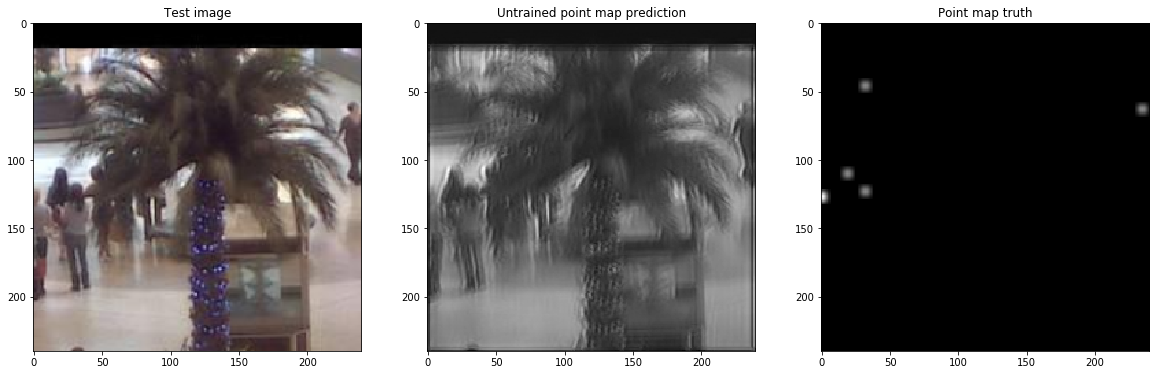

In [6]:
from sklearn.model_selection import train_test_split

X = X / 255 # scale X so values are 0-1
y = y * 1000 # amplify y so the network can more easily learn, then scale back predictions by the same amount to count points
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=True)

validation_data = (X_test, y_test)

print(y_test[0].shape)
print('point count',y_test[0].sum())

# put this back when done!  just so it doesn't print every time
model = get_model()

test_im = np.expand_dims(X_test[0], axis=0)
test_pm = y_test[0]

untrained_prediction = model.predict(test_im) / 1000
print('Sum of points from untrained model',untrained_prediction.sum())
untrained_prediction = np.squeeze(untrained_prediction, axis=0)
untrained_prediction = np.squeeze(untrained_prediction, axis=2)

# what does a predicted point map look like from an untrained model?
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Test image')
plt.imshow(X_test[0])
plt.subplot(132)
plt.title('Untrained point map prediction')
plt.imshow(untrained_prediction, interpolation='none', cmap='gray')
plt.subplot(133)
plt.title('Point map truth')
plt.imshow(np.squeeze(test_pm, axis=2), interpolation='none', cmap='gray')

plt.show()


As expected, the network is able to predict 'something' from a sample input. Next we'll try to fit the model to the training samples and see if it can learn to create the corresponding density map.

### Train a model to learn one image

Now I'll try to teach this small u-net to estimate the number of people in an image. The training data is simply a single image broken into an image pyramid. 

In [ ]:
epochs = 100
model = get_model()
model.fit(X_train, y_train, validation_data = validation_data, batch_size=len(X_train)//2, epochs = epochs)

#### ... removed the training output

After 100 training epochs the network is demonstrating some decent performance. The model is relatively low capacity and training on sample data takes less than 1 minute on a GTX1080.

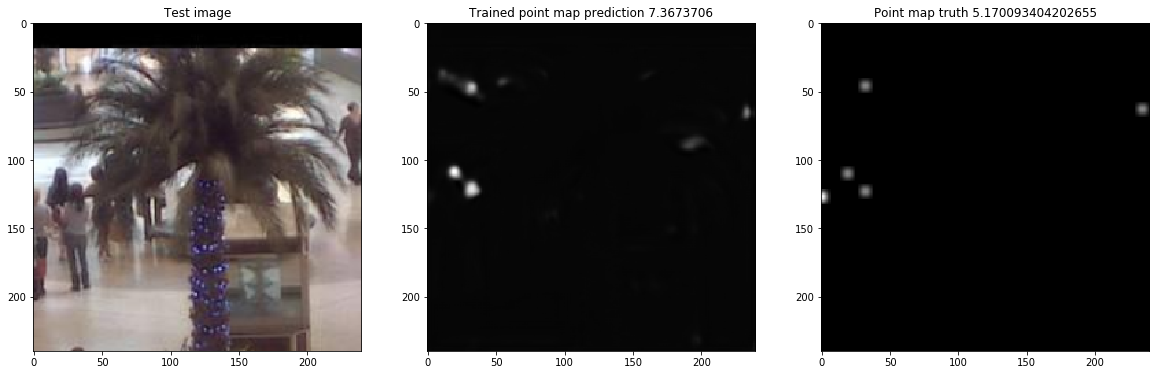

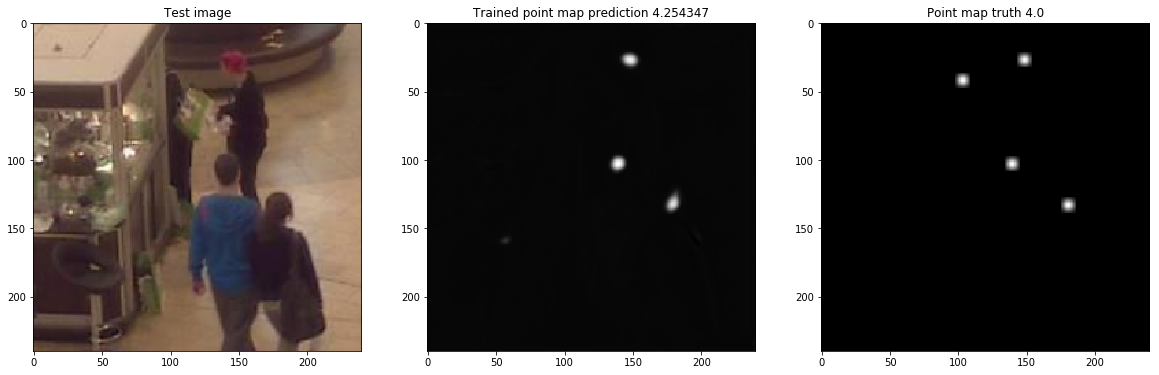

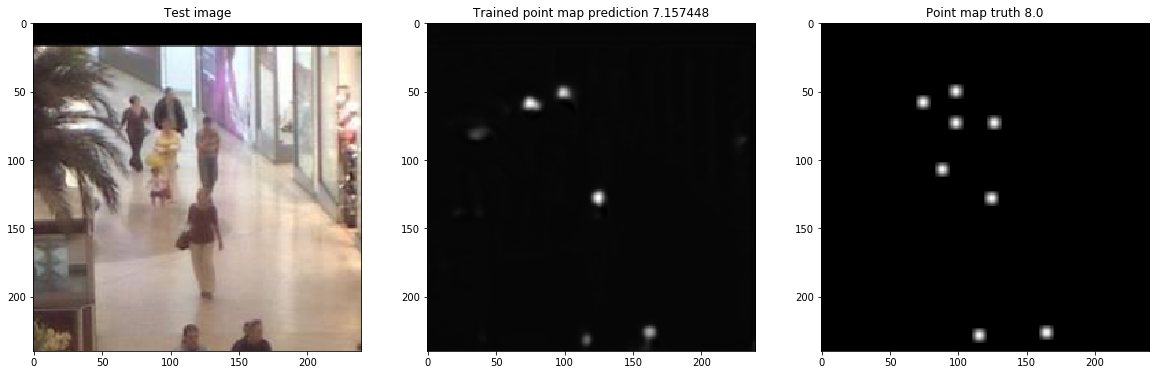

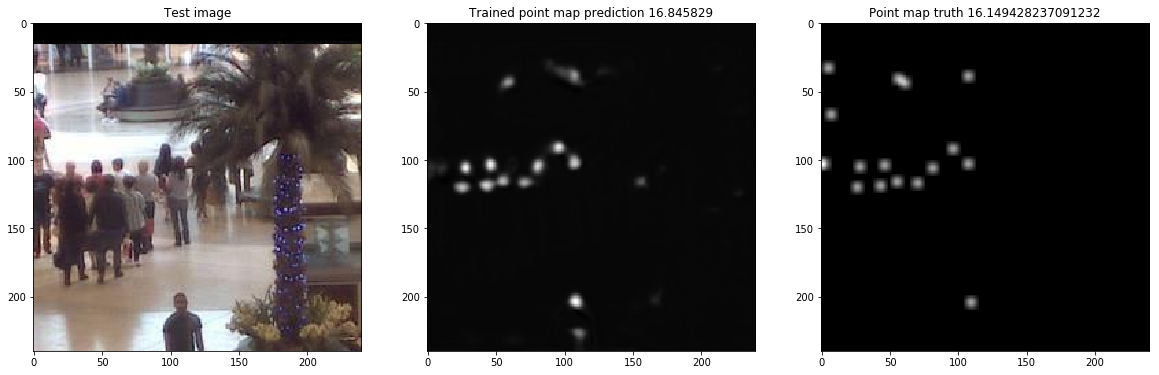

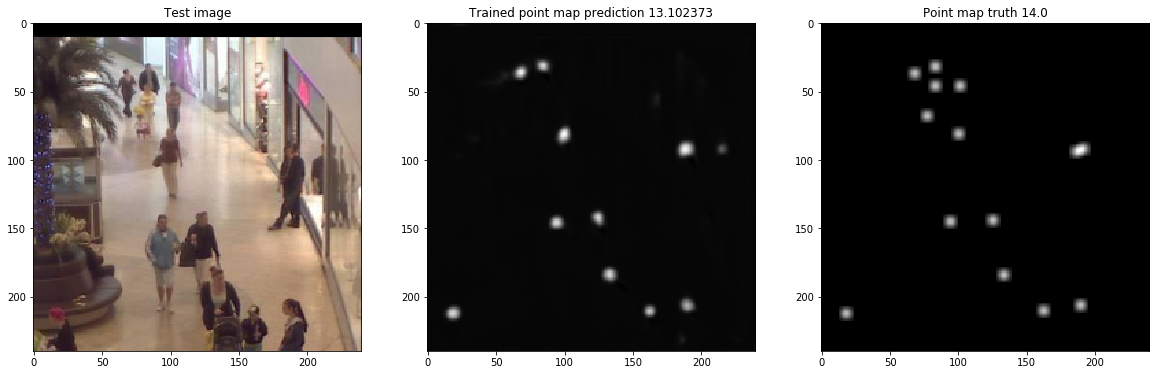

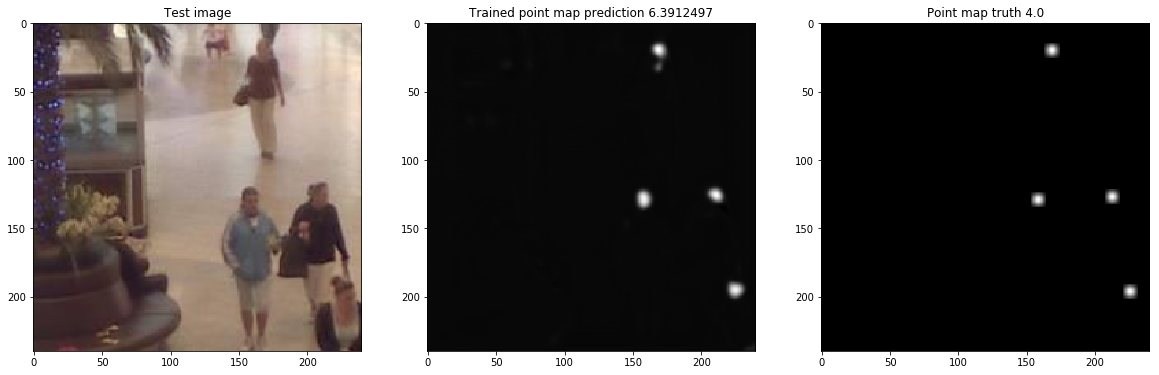

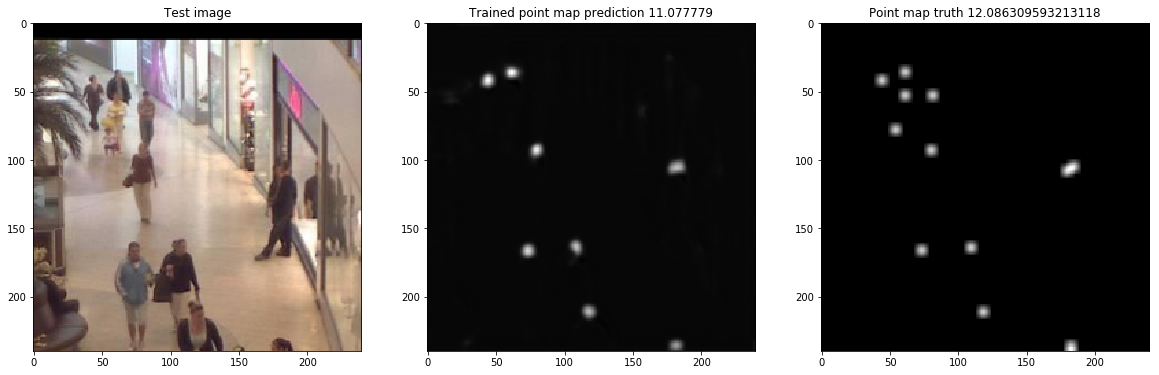

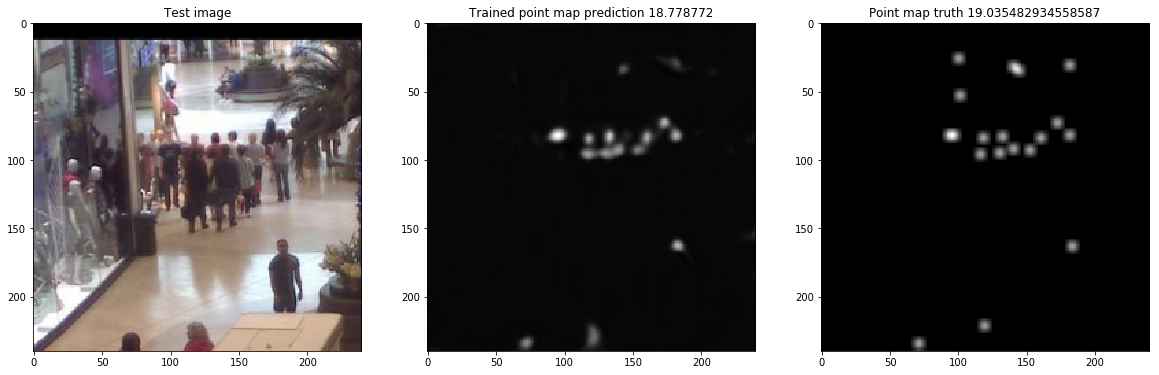

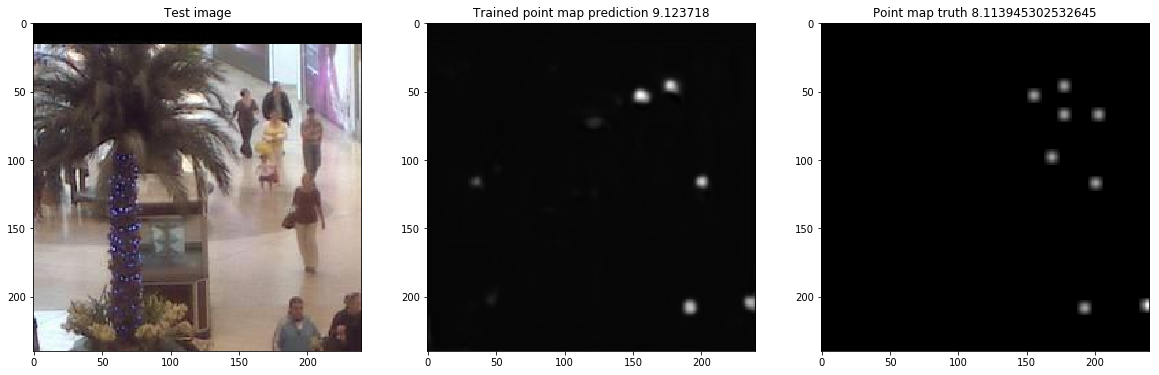

In [8]:
def plot_sample(sample_idx):

    test_im = np.expand_dims(X_test[sample_idx], axis=0)
    test_pm = y_test[sample_idx].squeeze(axis=2) / 1000

    trained_prediction = model.predict(test_im) / 1000
    trained_prediction = np.squeeze(trained_prediction, axis=0)
    trained_prediction = np.squeeze(trained_prediction, axis=2) 

    # what does a predicted point map look like from an untrained model?
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.title('Test image')
    plt.imshow(X_test[sample_idx])
    plt.subplot(132)
    plt.title('Trained point map prediction ' + str(trained_prediction.sum()))
    plt.imshow(trained_prediction, interpolation='none', cmap='gray')
    plt.subplot(133)
    plt.title('Point map truth ' + str(test_pm.sum()))
    plt.imshow(test_pm, interpolation='none', cmap='gray')

    plt.show()
    
plot_sample(0)
plot_sample(1)
plot_sample(2)
plot_sample(3)
plot_sample(4)
plot_sample(5)
plot_sample(6)
plot_sample(7)
plot_sample(8)

This small u-net is working as expected. Far from perfection but demonstrates the idea. 